<a href="https://colab.research.google.com/github/omar-shaaban742001/computer_vison_pytorch/blob/master/Deployment_of_pizza_steak_sushi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting start

In [4]:
import torch


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 28.29 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [7]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [8]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir , test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [9]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

#Setup the effnetb2 pretrained weights
effnetb2_wights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#Setup the transformation
effnetb2_transformer = effnetb2_wights.transforms()

#setup the pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights =effnetb2_wights)

#Freeze the model and change the classifer layer
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 173MB/s]


In [10]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        False
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 

In [12]:
from torch import nn
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features= 3 , bias=True)
  )

In [13]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
         col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

##Create function to effnetb2

In [14]:
def effnet_b2(num_classes: int,
              seed:int):
  """
  Create function to initialize the efficient net model and transformers
  """
  #Set up random seed
  torch.manual_seed(42)

  #Setup the effnetb2 pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  #Setup the transformation
  transformer = effnetb2_wights.transforms()

  #setup the pretrained model
  model = torchvision.models.efficientnet_b2(weights =weights)

    #Freeze the model and change the classifer layer
  for param in model.parameters():
    param.requires_grad = False

  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features= num_classes , bias=True)
  )

  return model , transformer


In [15]:
effnetb2 , effnetb2_transformers = effnet_b2(num_classes=3,
                                   seed = 42)

In [16]:
transforms

<module 'torchvision.transforms' from '/usr/local/lib/python3.10/dist-packages/torchvision/transforms/__init__.py'>

In [17]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

##Create dataloader for effnetb2

In [18]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2 , class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transformers,
    batch_size = 32
)

In [19]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2) , class_names

(15, 5, ['pizza', 'steak', 'sushi'])

##Training the effnetb2

In [20]:
#setup the optimzer
optimizer = torch.optim.Adam(params =effnetb2.parameters() ,lr = 0.001)

#Setup the loss function
loss_fn = nn.CrossEntropyLoss()

In [21]:
# from going_modular.going_modular import engine

# torch.manual_seed(42)
# effnetb2_results = engine.train(model = effnetb2,
#                        train_dataloader= train_dataloader_effnetb2,
#                        test_dataloader = test_dataloader_effnetb2,
#                        optimizer= optimizer,
#                        loss_fn = loss_fn,
#                        epochs = 10,
#                        device = device)

In [22]:
# from helper_functions import plot_loss_curves

# plot_loss_curves(effnetb2_results)

In [23]:
# from going_modular.going_modular import utils

# # Save the model
# utils.save_model(model=effnetb2,
#                  target_dir="models",
#                  model_name="pretrained_effnetb2_pizza_steak_sushi_20_percent.pth")

In [24]:
# from pathlib import Path

# # Get the model size in bytes then convert to megabytes
# pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
# print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

In [25]:
# effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
# effnetb2_total_params

In [26]:
# effnetb2_stats = {
#     "test_loss" : effnetb2_results["test_loss"][-1],
#     "test_accuracy" : effnetb2_results["test_acc"][-1],
#     "effnetb2_total_params" : effnetb2_total_params,
#     "effnetb2_size {MB}" : pretrained_effnetb2_model_size
# }
# effnetb2_stats

##Creating a ViT feature extractor

In [27]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [28]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [29]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s]


In [30]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

###Create DataLoaders for ViT

In [31]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

##Training ViT feature extractor

In [32]:
# from going_modular.going_modular import engine

# # Setup optimizer
# optimizer = torch.optim.Adam(params=vit.parameters(),
#                              lr=1e-3)
# # Setup loss function
# loss_fn = torch.nn.CrossEntropyLoss()

# # Train ViT model with seeds set for reproducibility
# set_seeds()
# vit_results = engine.train(model=vit,
#                            train_dataloader=train_dataloader_vit,
#                            test_dataloader=test_dataloader_vit,
#                            epochs=10,
#                            optimizer=optimizer,
#                            loss_fn=loss_fn,
#                            device=device)

In [33]:
# from helper_functions import plot_loss_curves

# plot_loss_curves(vit_results)

In [34]:
# # Save the model
# from going_modular.going_modular import utils

# utils.save_model(model=vit,
#                  target_dir="models",
#                  model_name="pretrained_vit_pizza_steak_sushi_20_percent.pth")

In [35]:
# from pathlib import Path

# # Get the model size in bytes then convert to megabytes
# pretrained_vit_model_size = Path("models/pretrained_vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
# print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

In [36]:
# # Count number of parameters in ViT
# vit_total_params = sum(torch.numel(param) for param in vit.parameters())
# vit_total_params

In [37]:
# # Create ViT statistics dictionary
# vit_stats = {"test_loss": vit_results["test_loss"][-1],
#              "test_acc": vit_results["test_acc"][-1],
#              "number_of_parameters": vit_total_params,
#              "model_size (MB)": pretrained_vit_model_size}

# vit_stats

##Prediction

In [42]:
#Get the pretraind weights
effnetb2_pretrained , effnetb2_transformers_pretrained = effnet_b2(num_classes=3,
                                   seed = 42)
effnetb2_pretrained.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Weights/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # Create ViT model and transforms
# vit_pretraind, vit_transforms_pretraind = create_vit_model(num_classes=3,
#                                        seed=42)
# vit_pretraind.load_state_dict(torch.load("/content/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth", map_location=torch.device('cpu')))

In [43]:
#get the test data into path\
from pathlib import Path
test_data_path = list(Path(test_dir).glob("*/*.jpg"))

In [44]:
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

#create a function to predict the test data
def prediction(path_list,
               model,
               device,
               transform,
               class_names):

  #create a list to store the info
  pred_list = []

  #loop through the dataset
  for path in tqdm(path_list):

    #set up dict to store the info for each image
    pred_dict = {}

    #get the image class
    pred_dict["Image_path"] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    #start the timer
    start_time = timer()

    #read an image from the path
    img = Image.open(path)

    # Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    #setup the eval mode and put the model to device
    model = model.to(device)
    model.eval()

    with torch.no_grad():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit , dim = 1)
      pred_label = torch.argmax(pred_prob , dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  # Return list of prediction dictionaries
  return pred_list

In [45]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = prediction(path_list=test_data_path,
                                          model=effnetb2_pretrained,
                                          transform=effnetb2_transformers,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [46]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,Image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.8756,sushi,0.2376,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.5828,sushi,0.2137,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9417,sushi,0.1513,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.7415,sushi,0.1544,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9680,sushi,0.1400,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

In [ ]:
# # Add EffNetB2 average prediction time to stats dictionary
# effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
# effnetb2_stats

In [ ]:
# # Make list of prediction dictionaries with ViT feature extractor model on test images
# vit_test_pred_dicts = prediction(path_list=test_data_path,
#                                      model=vit,
#                                      transform=vit_transforms,
#                                      class_names=class_names,
#                                      device="cpu")

In [ ]:
# # Check the first couple of ViT predictions on the test dataset
# vit_test_pred_dicts[:2]

In [ ]:
# # Turn vit_test_pred_dicts into a DataFrame
# import pandas as pd
# vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
# vit_test_pred_df.head()

In [ ]:
# # Count the number of correct predictions
# vit_test_pred_df.correct.value_counts()

In [ ]:
# # Calculate average time per prediction for ViT model
# vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
# print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

In [ ]:
# # Add average prediction time for ViT model on CPU
# vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
# vit_stats

##Deployment

In [47]:
def predict(img):

  #setup the timer
  start_time = timer()

  #transform the image
  img = effnetb2_transformers_pretrained(img).unsqueeze(0)

  #put the model in eval mode
  effnetb2_pretrained.eval()

  #Get the prediction
  with torch.no_grad():
    pred_prob = torch.softmax(effnetb2_pretrained(img) , dim = 1) #output is 2d tensor

  #Get a dict with all probs
  pred_label_prob = {class_names[i] : float(pred_prob[0][i]) for i in range(len(class_names))}

  #end timer
  end_time = timer()

  #the time took for a prediction
  predict_timer = round(end_time - start_time, 4)

  return pred_label_prob , predict_timer


{'pizza': 0.03865746781229973, 'steak': 0.023815687745809555, 'sushi': 0.9375268816947937}
0.2029


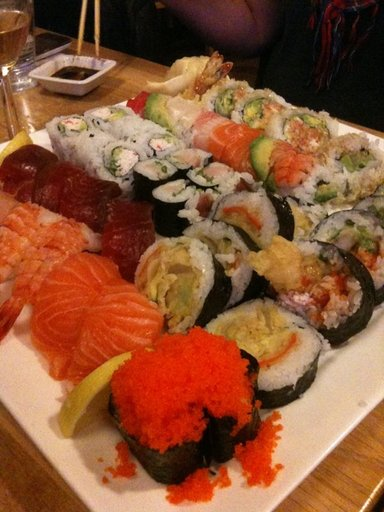

In [48]:
import random
test_data_list = list(Path(test_dir).glob("*/*.jpg"))

image = random.sample(test_data_list , k = 1)[0] #index here because the output is a list
image = Image.open(image)

pred_dict , pred_time = predict(image)
print(pred_dict)
print(pred_time)
image

In [49]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_list, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1383396.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg']]

##Building a Gradio interface

In [50]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account

In [51]:
# Create title, description
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNet b2 model to classify images of food as pizza, steak or sushi."

demo = gr.Interface(fn = predict,
                    examples= example_list,
                    description=description,
                    title= title,
                    inputs= gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")])

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c98514da4664cdd57d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


##Setting up requirements for hugging face

In [52]:
#Create directory for hugging face
import shutil
from pathlib import Path

food_vision_mini = Path("demos/food_vision_mini/")

food_vision_mini.mkdir(parents = True , exist_ok = True)

In [53]:

import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = food_vision_mini / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/food_vision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/food_vision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/food_vision_mini/examples/2582289.jpg


In [54]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

In [55]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "/content/drive/MyDrive/Colab Notebooks/Weights/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = food_vision_mini / effnetb2_foodvision_mini_model_path.split("/")[-1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move /content/drive/MyDrive/Colab Notebooks/Weights/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth to demos/food_vision_mini/pretrained_effnetb2_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [56]:
#Create effnetb2 in a file
%%writefile demos/food_vision_mini/model.py
import torchvision
import torch
from torch import nn
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url



def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

def effnet_b2(num_classes: int,
              seed:int):
  """
  Create function to initialize the efficient net model and transformers
  """
  #Set up random seed
  torch.manual_seed(42)

  #Setup the effnetb2 pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  #Setup the transformation
  transformer = effnetb2_wights.transforms()

  #setup the pretrained model
  model = torchvision.models.efficientnet_b2(weights =weights)

    #Freeze the model and change the classifer layer
  for param in model.parameters():
    param.requires_grad = False

  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features= num_classes , bias=True)
  )

  return model , transformer


Writing demos/food_vision_mini/model.py


In [58]:
%%writefile demos/food_vision_mini/app.py

import gradio as gr
import torch
import torchvision

from model import effnet_b2
from timeit import default_timer as timer

#Ceate a list of class names
class_names = ['Pizza' , 'Steak' , 'Shusi']

# Get an instant of the model
effnetb2_model, effnetb2_transformer = effnet_b2(num_classes = 3,
                           seed = 42)

# Load saved weights
effnetb2_model.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

#Creat an example list
example_list = [["examples/" + example] for example in os.listdir("examples/")]

#predict an image
def predict(img):

  #setup the timer
  start_time = timer()

  #transform the image
  img = effnetb2_transformer(img).unsqueeze(0)

  #put the model in eval mode
  effnetb2_model.eval()

  #Get the prediction
  with torch.no_grad():
    pred_prob = torch.softmax(effnetb2_model(img) , dim = 1) #output is 2d tensor

  #Get a dict with all probs
  pred_label_prob = {class_names[i] : float(pred_prob[0][i]) for i in range(len(class_names))}

  #end timer
  end_time = timer()

  #the time took for a prediction
  predict_timer = round(end_time - start_time, 4)

  return pred_label_prob , predict_timer


# Create title, description
title = "Pizze🍕 - Steak🥩 - Sushi🍣 Classification"
description = "An EfficientNet b2 model to classify images of food as pizza, steak or sushi."

demo = gr.Interface(fn = predict,
                    examples= example_list,
                    description=description,
                    title= title,
                    inputs= gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")])

demo.launch()


Overwriting demos/food_vision_mini/app.py


In [60]:
%%writefile  demos/food_vision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/food_vision_mini/requirements.txt


In [61]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/food_vision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
from google.colab import files
files.download("demos/foodvision_mini.zip")

  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 53%)
  adding: pretrained_effnetb2_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>